## imports
Data set is the monthly asylum seekers. Can be downloaded at 
http://popstats.unhcr.org/en/asylum_seekers_monthly

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx



pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


## Read in data and impute. 
Be sure to first run /data/convert_to_country_list.py 

In [2]:
df = pd.read_csv("../data/unhcr_popstats_export_asylum_seekers_monthly_all_data.csv",skiprows=3)
df.head()

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10
2,Australia,Afghanistan,1999,March,25
3,Australia,Afghanistan,1999,April,25
4,Australia,Afghanistan,1999,May,7


In [3]:
# rename columns
df.columns = ["destination","origin","year","month","value"]

# impute *s
df.value = df.value.apply(lambda x:int(x) if x !="*" else np.random.randint(1,4))
df.value = df.value.astype(int)
#print(df) # len=359130
df.head()

,destination,origin,year,month,value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10
2,Australia,Afghanistan,1999,March,25
3,Australia,Afghanistan,1999,April,25
4,Australia,Afghanistan,1999,May,7


In [4]:
# some country names were abbreviated causing issues when joining, fixing them here. 

df['origin'].replace("China, Hong Kong SAR", "Hong Kong SAR, China",inplace=True)
df['origin'].replace("Dem. People's Rep. of Korea", "Democratic People's Republic of Korea",inplace=True)
df['origin'].replace("Iran (Islamic Rep. of)", "Iran (Islamic Republic of)",inplace=True)
df['origin'].replace("China, Macao SAR", "Macao SAR, China",inplace=True)
df['origin'].replace("Czech Rep.", "Czech Republic",inplace=True)
df['origin'].replace("Rep. of Korea", "Republic of Korea",inplace=True)

df['origin'].replace("Central African Rep.", "Central African Republic",inplace=True)
df['origin'].replace("Tibetan", "China",inplace=True) ## No international country code for Tibet
df['origin'].replace("Lao People's Dem. Rep.", "Lao People's Democratic Republic",inplace=True)
df['origin'].replace("The former Yugoslav Rep. of Macedonia", "The former Yugoslav Republic of Macedonia",inplace=True)
df['origin'].replace("Dem. Rep. of the Congo", "Democratic Republic of the Congo",inplace=True)
df['origin'].replace("Palestinian", "Palestinian Territory, Occupied",inplace=True)

df['origin'].replace("Dominican Rep.", "Dominican Republic",inplace=True)
df['origin'].replace("Syrian Arab Rep.", "Syrian Arab Republic",inplace=True)
df['origin'].replace("Cabo Verde", "Cape Verde",inplace=True)
df['origin'].replace("United Rep. of Tanzania", "United Republic of Tanzania",inplace=True)
df['origin'].replace("Serbia and Kosovo: S/RES/1244 (1999)", "Serbia (and Kosovo: S/RES/1244 (1999))",inplace=True)
df['origin'].replace("Rep. of Moldova", "Republic of Moldova",inplace=True)

df['destination'].replace("The former Yugoslav Rep. of Macedonia", "The former Yugoslav Republic of Macedonia",inplace=True)
df['destination'].replace("USA (EOIR)", "United States of America",inplace=True)
df['destination'].replace("Serbia and Kosovo: S/RES/1244 (1999)", "Serbia (and Kosovo: S/RES/1244 (1999))",inplace=True)
df['destination'].replace("Rep. of Korea", "Republic of Korea",inplace=True)
df['destination'].replace("USA (INS/DHS)", "United States of America",inplace=True)
df['destination'].replace("Czech Rep.", "Czech Republic",inplace=True)


In [5]:
# make sure you ran convert_to_country_list.py in /data already
df_cc = pd.read_csv("../data/country_list.csv")
#print(df_cc)
cc_names = set(df_cc.name_en)
#print(len(cc_names)) #227



In [6]:
df_origin = set(df.origin)
#print(len(df_origin)) #205

missing_origin = []
for c in df_origin:
    if c in cc_names:
        pass
    else:
        missing_origin.append(c)

print(missing_origin)
# we have country names in the data that was not in the country list

['Stateless', 'Various/unknown']


In [7]:
df_destination = set(df.destination)
#print(len(df_destination)) #45

missing_destination = []
for c in df_destination:
    if c in cc_names:
        pass
    else:
        missing_destination.append(c)

print(missing_destination)
# we have country names in the data that was not in the country list

[]


In [22]:
# examine "Various/unknown" origin
df_unknown = df[df["origin"]=="Various/unknown"]
#print(len(df_unknown)) #3365
#print(df_unknown["value"].sum()) #164895
unknown_by_year = df_unknown.groupby(["destination", "year"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(unknown_by_year)


                                           destination  year  value
180                                            Germany  2016  18125
179                                            Germany  2015  15297
397  United Kingdom of Great Britain and Northern I...  1999   9080
398  United Kingdom of Great Britain and Northern I...  2000   8975
178                                            Germany  2014   5406
181                                            Germany  2017   4679
28                                             Austria  2015   4453
29                                             Austria  2016   3617
182                                            Germany  2018   3455
183                                             Greece  2000   3004
177                                            Germany  2013   2166
420                           United States of America  2002   2146
166                                            Germany  2002   2018
225                                             

In [24]:
# examine "Stateless" origin

df_stateless = df[df["origin"]=="Stateless"]
#print(len(df_stateless)) #3762
#print(df_stateless["value"].sum()) #116091
stateless_by_year = df_stateless.groupby(["destination", "year"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(unknown_by_year)



                                           destination  year  value
180                                            Germany  2016  18125
179                                            Germany  2015  15297
397  United Kingdom of Great Britain and Northern I...  1999   9080
398  United Kingdom of Great Britain and Northern I...  2000   8975
178                                            Germany  2014   5406
181                                            Germany  2017   4679
28                                             Austria  2015   4453
29                                             Austria  2016   3617
182                                            Germany  2018   3455
183                                             Greece  2000   3004
177                                            Germany  2013   2166
420                           United States of America  2002   2146
166                                            Germany  2002   2018
225                                             

In [26]:
# merging with country_list.csv
df = df.merge(df_cc,how='inner',left_on="origin",right_on="name_en")
df.rename(columns=dict(zip(df_cc.columns,[c+"_origin" for c in df_cc.columns])),inplace=True)

df = df.merge(df_cc,how='inner',left_on="destination",right_on="name_en")
df.rename(columns=dict(zip(df_cc.columns,[c+"_destination" for c in df_cc.columns])),inplace=True)


df.head()
#print(len(df)) # 372054

,destination,origin,year,month,value,country_code_origin,name_en_origin,region_code_origin,region_code_en_origin,country_code_destination,name_en_destination,region_code_destination,region_code_en_destination,country_code_origin,name_en_origin,region_code_origin,region_code_en_origin,country_code_destination,name_en_destination,region_code_destination,region_code_en_destination
0,Australia,Afghanistan,1999,January,8,AFG,Afghanistan,142.0,Asia,AUL,Australia,9,Oceania,AFG,Afghanistan,142,Asia,AUL,Australia,9,Oceania
1,Australia,Afghanistan,1999,February,10,AFG,Afghanistan,142.0,Asia,AUL,Australia,9,Oceania,AFG,Afghanistan,142,Asia,AUL,Australia,9,Oceania
2,Australia,Afghanistan,1999,March,25,AFG,Afghanistan,142.0,Asia,AUL,Australia,9,Oceania,AFG,Afghanistan,142,Asia,AUL,Australia,9,Oceania
3,Australia,Afghanistan,1999,April,25,AFG,Afghanistan,142.0,Asia,AUL,Australia,9,Oceania,AFG,Afghanistan,142,Asia,AUL,Australia,9,Oceania
4,Australia,Afghanistan,1999,May,7,AFG,Afghanistan,142.0,Asia,AUL,Australia,9,Oceania,AFG,Afghanistan,142,Asia,AUL,Australia,9,Oceania


## Where asylum applications come from

In [10]:
# overall historical total
outflows = df.groupby(["origin"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(outflows)



                                                origin    value
176                               Syrian Arab Republic  1177380
0                                          Afghanistan  1109596
84                                                Iraq  1018333
158             Serbia (and Kosovo: S/RES/1244 (1999))   643710
37                                               China   458680
148                                 Russian Federation   420529
83                          Iran (Islamic Republic of)   419358
134                                           Pakistan   394234
131                                            Nigeria   342944
165                                            Somalia   323734
57                                             Eritrea   287109
185                                             Turkey   278613
115                                             Mexico   218888
1                                              Albania   217398
171                                     

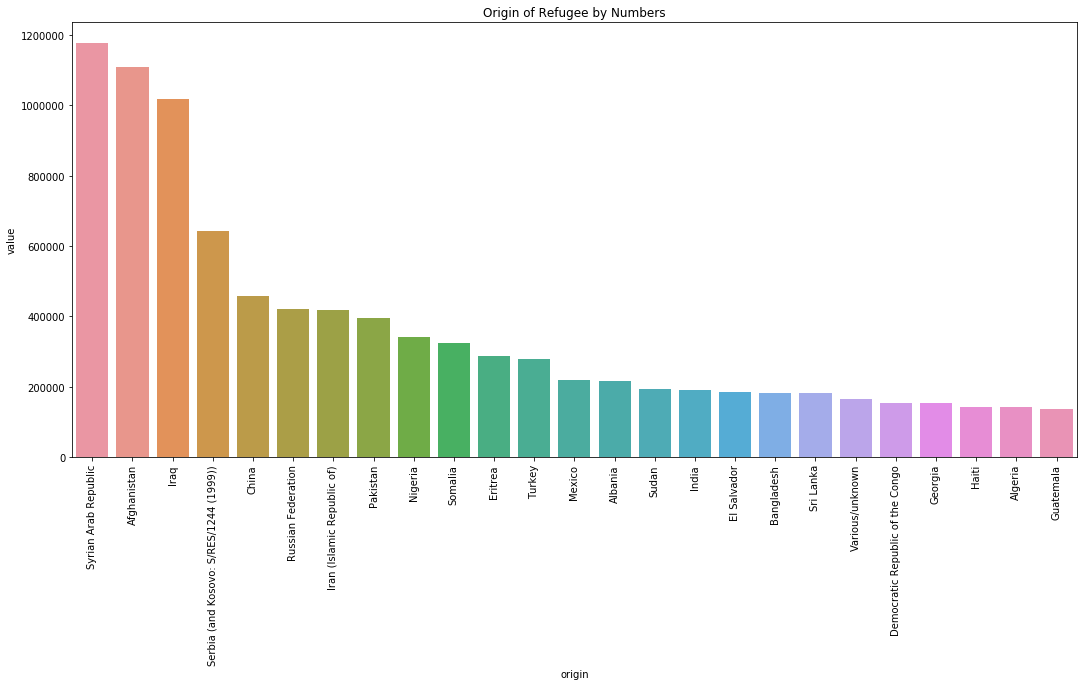

In [11]:
outflows_graph = outflows.head(25)

plt.figure(figsize=(18,8));
ax = sns.barplot(outflows_graph.origin, outflows_graph.value);
plt.title("Origin of asylum applications  by Numbers");
plt.xticks(rotation='vertical');
plt.show();




In [12]:
# break down by year
outflows_by_year = df.groupby(["origin", "year"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(outflows_by_year)

                                      origin  year   value
3264                    Syrian Arab Republic  2015  382513
3265                    Syrian Arab Republic  2016  341030
16                               Afghanistan  2015  258518
17                               Afghanistan  2016  224759
1602                                    Iraq  2015  186617
1603                                    Iraq  2016  160906
3263                    Syrian Arab Republic  2014  148729
2903  Serbia (and Kosovo: S/RES/1244 (1999))  1999  115491
18                               Afghanistan  2017  112610
3266                    Syrian Arab Republic  2017  101031
1604                                    Iraq  2017   92888
2919  Serbia (and Kosovo: S/RES/1244 (1999))  2015   88038
19                               Afghanistan  2018   76417
1601                                    Iraq  2014   68591
36                                   Albania  2015   67432
3267                    Syrian Arab Republic  2018   607

In [13]:
# past 5 years
outflows_by_year_recent = outflows_by_year[outflows_by_year['year']>=2014]
print(outflows_by_year_recent)

                                         origin  year   value
3264                       Syrian Arab Republic  2015  382513
3265                       Syrian Arab Republic  2016  341030
16                                  Afghanistan  2015  258518
17                                  Afghanistan  2016  224759
1602                                       Iraq  2015  186617
1603                                       Iraq  2016  160906
3263                       Syrian Arab Republic  2014  148729
18                                  Afghanistan  2017  112610
3266                       Syrian Arab Republic  2017  101031
1604                                       Iraq  2017   92888
2919     Serbia (and Kosovo: S/RES/1244 (1999))  2015   88038
19                                  Afghanistan  2018   76417
1601                                       Iraq  2014   68591
36                                      Albania  2015   67432
3267                       Syrian Arab Republic  2018   60777
15      

## Where asylum applications  go

In [14]:
# historical overall
inflows = df.groupby(["destination"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(inflows)

                                          destination    value
14                                            Germany  2443113
43                           United States of America  1578791
13                                             France  1068605
42  United Kingdom of Great Britain and Northern I...   865349
38                                             Sweden   717598
41                                             Turkey   668032
19                                              Italy   578530
6                                              Canada   549212
2                                             Austria   482860
3                                             Belgium   399746
27                                        Netherlands   391674
39                                        Switzerland   391494
16                                            Hungary   327610
15                                             Greece   317437
1                                           Australia  

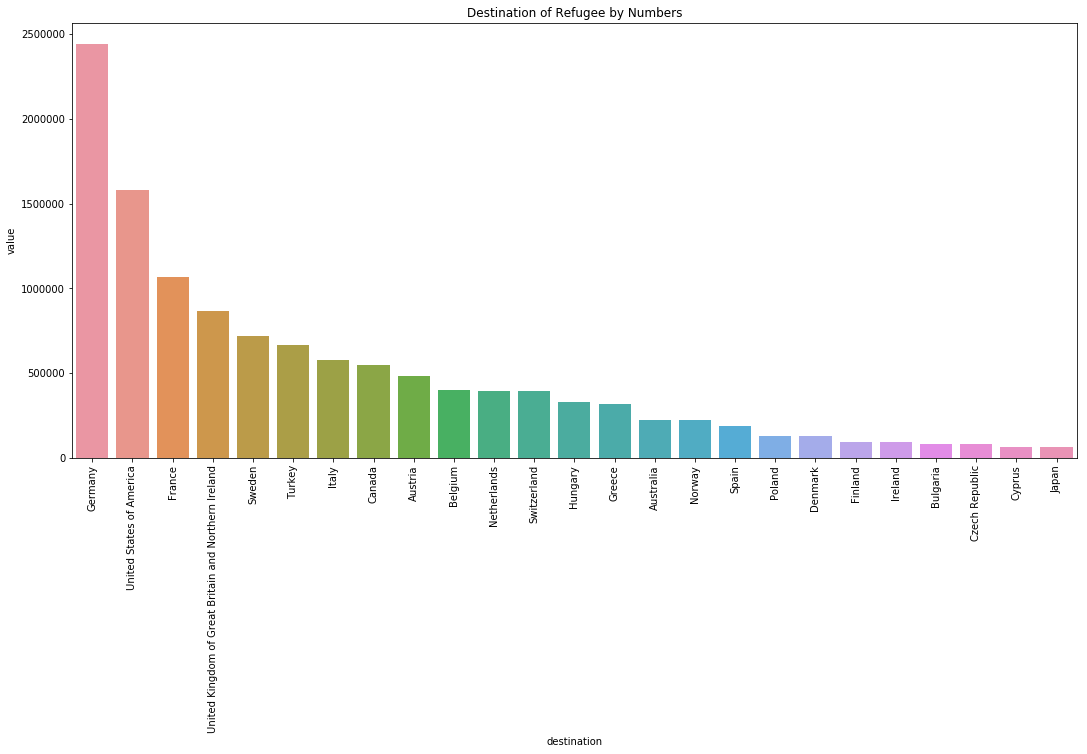

In [15]:
inflows_graph = inflows.head(25)

plt.figure(figsize=(18,8));
ax = sns.barplot(inflows_graph.destination, inflows_graph.value);
plt.title("Destination of asylum applications  by Numbers");
plt.xticks(rotation='vertical');
plt.show();





In [16]:
# break down destination by year
inflows_by_year = df.groupby(["destination", "year"])["value"].sum().reset_index().sort_values("value", ascending=False)
print(inflows_by_year)

                                           destination  year   value
274                                            Germany  2016  724808
273                                            Germany  2015  442931
811                           United States of America  2017  262156
810                           United States of America  2016  205109
275                                            Germany  2017  182916
313                                            Hungary  2015  174689
272                                            Germany  2014  173825
715                                             Sweden  2015  156905
809                           United States of America  2015  136196
769                                             Turkey  2015  133642
364                                              Italy  2017  127332
771                                             Turkey  2017  123983
363                                              Italy  2016  122626
276                               

In [17]:
# past 5 years
inflows_by_year_recent = inflows_by_year[inflows_by_year['year']>=2014]
print(inflows_by_year_recent)

                                           destination  year   value
274                                            Germany  2016  724808
273                                            Germany  2015  442931
811                           United States of America  2017  262156
810                           United States of America  2016  205109
275                                            Germany  2017  182916
313                                            Hungary  2015  174689
272                                            Germany  2014  173825
715                                             Sweden  2015  156905
809                           United States of America  2015  136196
769                                             Turkey  2015  133642
364                                              Italy  2017  127332
771                                             Turkey  2017  123983
363                                              Italy  2016  122626
276                               

## asylum applications from-to plot

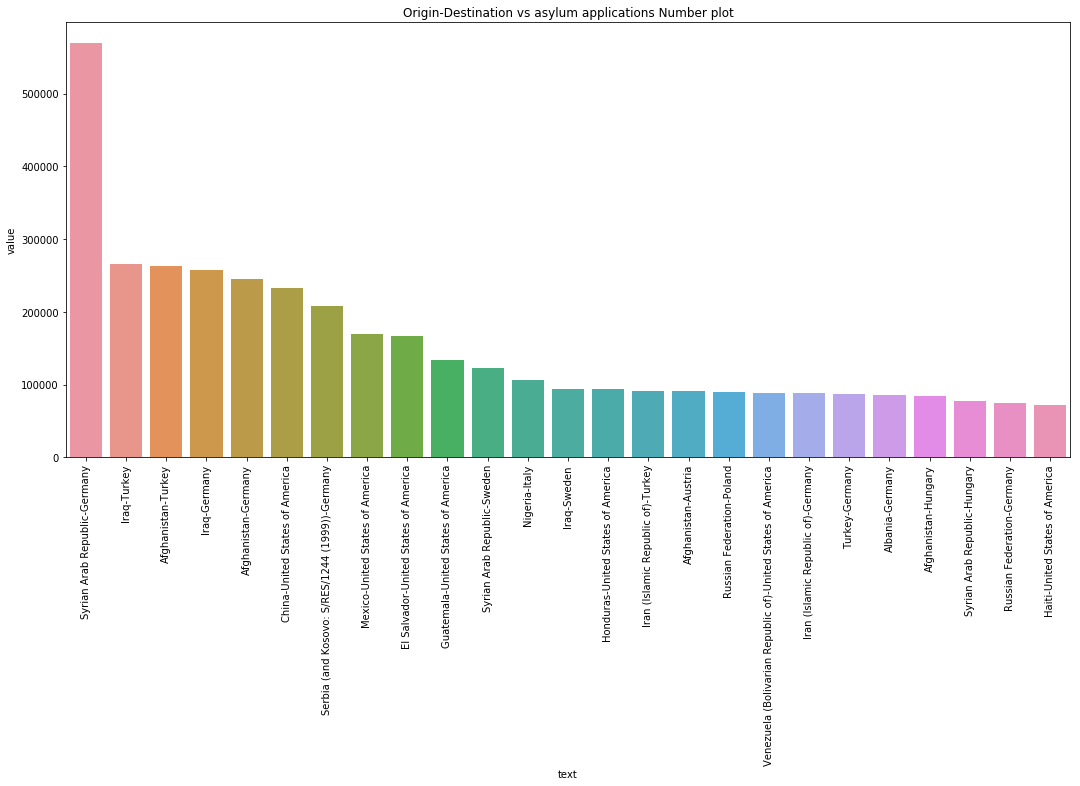

In [25]:
from_to_values = df.groupby(["origin",'destination'])['value'].sum().reset_index().sort_values("value", ascending=False)
#print(from_to_values)

from_to_values["text"] = from_to_values.apply(lambda row:row["origin"]+"-"+row["destination"],axis=1)
from_to_values = from_to_values.sort_values(["value"],ascending=False).head(25)

plt.figure(figsize=(18,8));
ax = sns.barplot(from_to_values.text, from_to_values.value);
plt.title("Origin-Destination vs asylum applications Number plot");
plt.xticks(rotation='vertical');
plt.show();


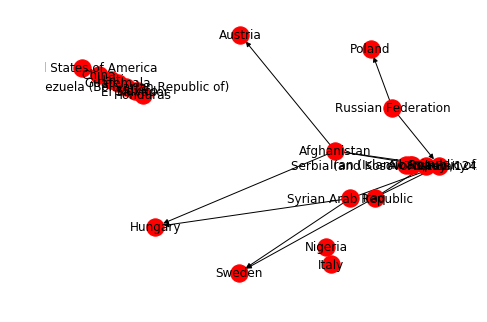

In [19]:
edge_list=from_to_values[['origin', 'destination', 'value']]
edges = list(map(tuple, list(edge_list.values)))
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)

#print(edges)
nx.draw(DG,with_labels=True)

plt.show()